Fix potential bugs in formulation of edge Neural ODE, i.e. when doing the forward pass over the `ODEFunc`, ensure we return zeros for the latent dimension block of the vector, so it does not calculate gradients over those, try learning with only the ICs

In [1]:
run_tc1 = False
run_global=False

In [2]:
import pandas as pd

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim

In [4]:
adjoint=True

In [5]:
!pip install --user -q torchdiffeq

In [6]:
if adjoint:
    from torchdiffeq import odeint_adjoint as odeint
else:
    from torchdiffeq import odeint

In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [8]:
import numpy as np
import scipy.linalg as la
import scipy.sparse as sparse
import matplotlib.pyplot as plt

In [9]:
import re
import os
import time

In [10]:
%matplotlib inline

In [11]:
plt.rc("axes.spines", right=True, top=True)
plt.rc("figure", dpi=300, 
       figsize=(9, 3)
      )
plt.rc("font", family="serif")
plt.rc("legend", edgecolor="none", frameon=True)
plt.style.use("dark_background")

In [12]:
import edge_utils as edut

In [13]:
ed_2161, sd_2161 = edut.load_edge_data_blobfree(2161)

In [14]:
theta_s_2161, theta_e_2161 = np.linspace(0, 360, 512)[160] + 1.2 * 180 - 360, np.linspace(0, 360, 512)[320] + 1.2 * 180 - 360
print("Range of angles for CR2161: {} {}".format(theta_s_2161, theta_e_2161))

Range of angles for CR2161: -31.279843444227026 81.44031311154595


In [15]:
nTimes, nTheta_2161, nSims_2161 = ed_2161.shape
nTimes, nTheta_2161, nSims_2161

(90, 160, 278)

In [16]:
theta_grid = np.linspace(np.ceil(theta_s_2161), np.ceil(theta_e_2161), nTheta_2161)

In [17]:
def getRValuesAllSims(edge_data_matrix):
    """
    Return r values for all sims at once so we don't lose time in training processing r values repeatedly
    """
    r_data_matrix = np.zeros(edge_data_matrix.shape)
    nsims = edge_data_matrix.shape[2]
    for i in range(nsims):
        r_vals, theta_vals = edut.getRValues(edge_data_matrix, simIdx=i, minStartIdx=0)
        r_data_matrix[:, :, i] = r_vals

    return r_data_matrix

In [18]:
rd_2161 = getRValuesAllSims(ed_2161)

In [19]:
plt.rc("axes.spines", right=True, top=True)
plt.rc("figure", dpi=300, 
       figsize=(9, 3)
      )
plt.rc("font", family="serif")
plt.rc("legend", edgecolor="none", frameon=True)
plt.style.use("dark_background")

In [20]:
import edge_utils as edut

In [21]:
# we are removing some data where the edge detection is not necessarily super reliable.
sims_to_remove = np.array([33, 39, 63, 73, 113, 128, 131, 142, 193, 218, 253, 264, 273, 312, 313, 324])

In [22]:
ed_2161, sd_2161 = edut.load_edge_data_blobfree(2161)

In [23]:
theta_s_2161, theta_e_2161 = np.linspace(0, 360, 512)[160] + 1.2 * 180 - 360, np.linspace(0, 360, 512)[320] + 1.2 * 180 - 360
print("Range of angles for CR2161: {} {}".format(theta_s_2161, theta_e_2161))

Range of angles for CR2161: -31.279843444227026 81.44031311154595


In [24]:
nTimes, nTheta_2161, nSims_2161 = ed_2161.shape
nTimes, nTheta_2161, nSims_2161

(90, 160, 278)

In [25]:
theta_grid = np.linspace(np.ceil(theta_s_2161), np.ceil(theta_e_2161), nTheta_2161)

In [26]:
sd_modified = np.setdiff1d(sd_2161, sims_to_remove)

In [27]:
len(sd_modified)

262

In [28]:
# # extract training and test sets. for now just random.

# from numpy.random import Generator, PCG64
# rng = Generator(PCG64())

# nTrain = int(np.floor(0.8 * len(sd_modified)))
# nTest = len(sd_modified) - nTrain

# nTrain, nTest

In [29]:
scratch_dir = os.environ["PSCRATCH"]
trained_models = os.path.join(scratch_dir, "trained_models_1d_edge")

In [30]:
sd_train = np.load(os.path.join(scratch_dir, trained_models, "sd_train.npy"))
sd_test  = np.load(os.path.join(scratch_dir, trained_models, "sd_test.npy"))
sd_calib = np.load(os.path.join(scratch_dir, trained_models, "sd_calib.npy"))

In [31]:
sd_test.shape

(53,)

In [32]:
def getRValuesAllSims(edge_data_matrix):
    """
    Return r values for all sims at once so we don't lose time in training processing r values repeatedly
    """
    r_data_matrix = np.zeros(edge_data_matrix.shape)
    nsims = edge_data_matrix.shape[2]
    for i in range(nsims):
        r_vals, theta_vals = edut.getRValues(edge_data_matrix, simIdx=i, minStartIdx=0)
        r_data_matrix[:, :, i] = r_vals

    return r_data_matrix

In [33]:
rd_2161 = getRValuesAllSims(ed_2161)

### Set up for Parametrized and Regular Neural ODEs

In [34]:
# get the param list for CR2161, get background values as well

In [35]:
cme_params = pd.read_csv("./restarts_CR2161.csv")
cme_params.head()

,Radius,BStrength,ApexHeight,OrientationCme,iHelicity,restartdir,realization
0,0.58375,22.526622,0.682075,204.725,1,4,4
1,0.52625,6.919483,0.519179,164.225,1,4,4
2,0.72625,5.087500,0.662022,233.975,1,4,4
3,0.36125,18.360770,0.420743,200.675,-1,4,4
4,0.69125,8.127120,0.735101,184.925,1,4,4


In [36]:
bg_params = pd.read_csv("./backgrounds_CR2161.csv")
bg_params

,FactorB0,PoyntingFluxPerBSi,LperpTimesSqrtBSi
0,0.5987,547686.9,259077.5
1,0.6876,514248.2,170240.5
2,0.7334,437169.7,242477.4
3,0.8010,378833.7,147856.5
4,0.9431,491082.5,205150.8
5,1.0077,349735.7,230084.9
6,1.0404,668772.0,278163.0
7,1.0921,463650.6,299730.0
8,1.2009,337215.4,113682.7
9,1.2292,583776.3,160912.2


In [37]:
unique_bg = cme_params.restartdir.unique()
unique_bg

array([ 4, 12])

In [38]:
bg_params.FactorB0[3]

0.801

In [39]:
bg_params.shape

(30, 3)

In [40]:
# identify which rows correspond to a particular background
cme_param_bg_idx = []
for bg in unique_bg:
    cme_param_bg_idx.append(np.array((cme_params.restartdir == bg).to_list()))

# now append columns to cme_params dataframe to merge

In [41]:
cme_params

,Radius,BStrength,ApexHeight,OrientationCme,iHelicity,restartdir,realization
0,0.58375,22.526622,0.682075,204.725,1,4,4
1,0.52625,6.919483,0.519179,164.225,1,4,4
2,0.72625,5.087500,0.662022,233.975,1,4,4
3,0.36125,18.360770,0.420743,200.675,-1,4,4
4,0.69125,8.127120,0.735101,184.925,1,4,4
...,...,...,...,...,...,...,...
295,0.36250,32.665259,0.436133,197.750,-1,12,5
296,0.46250,26.757500,0.443711,224.750,1,12,5
297,0.76250,16.930533,0.874492,215.750,-1,12,5
298,0.61250,21.948929,0.553164,188.750,1,12,5


In [42]:
bg_params_to_insert = np.zeros((cme_params.shape[0], bg_params.shape[1]))
for bg_idx, bg in enumerate(unique_bg):
    bg_params_to_insert[cme_param_bg_idx[bg_idx], 0] = bg_params.FactorB0[bg - 1]
    bg_params_to_insert[cme_param_bg_idx[bg_idx], 1] = bg_params.PoyntingFluxPerBSi[bg - 1]
    bg_params_to_insert[cme_param_bg_idx[bg_idx], 2] = bg_params.LperpTimesSqrtBSi[bg - 1]

cme_params["FactorB0"] = pd.Series(bg_params_to_insert[:, 0])
cme_params["PoyntingFluxPerBSi"] = pd.Series(bg_params_to_insert[:, 1])
cme_params["LperpTimesSqrtBSi"] = pd.Series(bg_params_to_insert[:, 2])
cme_params["SimID"] = pd.Series(np.linspace(31, 330, 300))
sim_idx_successful = sd_2161 - 30 - 1
sim_idx_to_drop = np.setdiff1d(np.linspace(0, 299, 300), sim_idx_successful).astype(int).tolist()

sim_idx_to_drop
cme_params.drop(["restartdir"], axis=1, inplace=True)
cme_params.drop(sim_idx_to_drop, inplace=True)
cme_params.drop(["SimID"], axis=1, inplace=True)
cme_params

,Radius,BStrength,ApexHeight,OrientationCme,iHelicity,realization,FactorB0,PoyntingFluxPerBSi,LperpTimesSqrtBSi
0,0.58375,22.526622,0.682075,204.725,1,4,0.8010,378833.7,147856.5
1,0.52625,6.919483,0.519179,164.225,1,4,0.8010,378833.7,147856.5
2,0.72625,5.087500,0.662022,233.975,1,4,0.8010,378833.7,147856.5
3,0.36125,18.360770,0.420743,200.675,-1,4,0.8010,378833.7,147856.5
4,0.69125,8.127120,0.735101,184.925,1,4,0.8010,378833.7,147856.5
...,...,...,...,...,...,...,...,...,...
294,0.73750,15.331483,0.721367,170.750,-1,5,1.3016,304514.4,283042.3
295,0.36250,32.665259,0.436133,197.750,-1,5,1.3016,304514.4,283042.3
296,0.46250,26.757500,0.443711,224.750,1,5,1.3016,304514.4,283042.3
297,0.76250,16.930533,0.874492,215.750,-1,5,1.3016,304514.4,283042.3


In [43]:
cme_params.ApexHeight.min(), cme_params.ApexHeight.max()

(0.280873828, 0.928935547)

In [44]:
0.875 * 0.3, 1.25 * 0.8

(0.2625, 1.0)

In [45]:
cme_params.BStrength.min(), cme_params.BStrength.max()

(5.0875, 42.76293137)

In [46]:
(0.5 / 0.8) * 19.25 * 0.37, (2.0 / 0.3) * 19.25 * 0.37

(4.4515625, 47.483333333333334)

In [47]:
cme_params.OrientationCme.min(), cme_params.OrientationCme.max()

(155.225, 244.775)

In [48]:
200 - 45, 200 + 45

(155, 245)

In [49]:
type(cme_params.min())
# cme_params.max()

pandas.core.series.Series

In [50]:
cme_p_min = cme_params.min()
cme_p_min.BStrength = 4.4516
cme_p_min.Radius = 0.3
cme_p_min.OrientationCme = 155
cme_p_min.iHelicity = -1
cme_p_min.ApexHeight = 0.2625
cme_p_min.realization = 1
cme_p_min.FactorB0 = 0.54
cme_p_min.PoyntingFluxPerBSi = 0.3e6
cme_p_min.LperpTimesSqrtBSi = 0.3e5

cme_p_min

Radius                     0.3000
BStrength                  4.4516
ApexHeight                 0.2625
OrientationCme           155.0000
iHelicity                 -1.0000
realization                1.0000
FactorB0                   0.5400
PoyntingFluxPerBSi    300000.0000
LperpTimesSqrtBSi      30000.0000
dtype: float64

In [51]:
cme_p_max = cme_params.max()
cme_p_max.BStrength = 47.4833
cme_p_max.Radius = 0.8
cme_p_max.OrientationCme = 245
cme_p_max.iHelicity = 1
cme_p_max.ApexHeight = 1
cme_p_max.realization = 12
cme_p_max.FactorB0 = 2.7
cme_p_max.PoyntingFluxPerBSi = 1.1e6
cme_p_max.LperpTimesSqrtBSi = 3e5

cme_p_max

Radius                8.000000e-01
BStrength             4.748330e+01
ApexHeight            1.000000e+00
OrientationCme        2.450000e+02
iHelicity             1.000000e+00
realization           1.200000e+01
FactorB0              2.700000e+00
PoyntingFluxPerBSi    1.100000e+06
LperpTimesSqrtBSi     3.000000e+05
dtype: float64

In [52]:
# define min and max series in terms of actual ranges of parameters?
# cme_min = pd.Series([0.3, 0.54, 0.3e6, 0.3e5, ])

In [53]:
# now rescale each column of `cme_params` to lie between 0 and 1.

# cme_params_norm = (cme_params - cme_params.min()) / (cme_params.max() - cme_params.min())
cme_params_norm = (cme_params - cme_p_min) / (cme_p_max - cme_p_min)
cme_params_norm

,Radius,BStrength,ApexHeight,OrientationCme,iHelicity,realization,FactorB0,PoyntingFluxPerBSi,LperpTimesSqrtBSi
0,0.5675,0.420040,0.568916,0.5525,1.0,0.272727,0.120833,0.098542,0.436506
1,0.4525,0.057350,0.348039,0.1025,1.0,0.272727,0.120833,0.098542,0.436506
2,0.8525,0.014777,0.541725,0.8775,1.0,0.272727,0.120833,0.098542,0.436506
3,0.1225,0.323231,0.214567,0.5075,0.0,0.272727,0.120833,0.098542,0.436506
4,0.7825,0.085414,0.640815,0.3325,1.0,0.272727,0.120833,0.098542,0.436506
...,...,...,...,...,...,...,...,...,...
294,0.8750,0.252834,0.622193,0.1750,0.0,0.363636,0.352593,0.005643,0.937194
295,0.1250,0.655648,0.235434,0.4750,0.0,0.363636,0.352593,0.005643,0.937194
296,0.3250,0.518360,0.245710,0.7750,1.0,0.363636,0.352593,0.005643,0.937194
297,0.9250,0.289994,0.829820,0.6750,0.0,0.363636,0.352593,0.005643,0.937194


In [54]:
cme_params_to_augment = cme_params_norm.to_numpy()
cme_params_to_augment.shape

(278, 9)

### Setup for CNN Architecture

In [55]:
param_dim = cme_params_to_augment.shape[1]
param_dim

9

In [56]:
# now augment dataset with these scaled values.
rd_2161.shape

(90, 160, 278)

In [57]:
data_dim = rd_2161.shape[1]
data_dim

160

In [58]:
input_dim = rd_2161.shape[1]
input_dim, param_dim

(160, 9)

In [59]:
augmented_r = np.zeros((rd_2161.shape[0], data_dim + param_dim, rd_2161.shape[2]))
augmented_r[:, :(data_dim), :] = rd_2161
for iii in range(rd_2161.shape[2]):
    augmented_r[:, (data_dim):, iii] = cme_params_to_augment[iii, :]

In [60]:
augmented_r.shape

(90, 169, 278)

In [61]:
class RunningAverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self, momentum=0.99):
        self.momentum = momentum
        self.losses = []
        self.reset()

    def reset(self):
        self.val = None
        self.avg = 0

    def update(self, val):
        if self.val is None:
            self.avg = val
        else:
            self.avg = self.avg * self.momentum + val * (1 - self.momentum)
        self.val = val
        self.losses.append(self.avg)

In [62]:
def getDataForSim(edge_data_matrix, r_data_matrix, sim_data, sid):
    """
    Take in a randomly chosen sim from the training set and return the following:
    y0_train_torch
    y_train_torch
    i.e. IC and data in torch tensor format on Device
    t_train_torch
    and correct sim_index from sim_data
    """
    
    sim_index = np.argwhere(sim_data == sid)[0][0]
    
    r_sim = r_data_matrix[:, :, sim_index]
    
    tMinIdx, tMin, tMaxIdx, tMax = edut.getTMinTMax(edge_data_matrix, simIdx=sim_index)
    
    r_sim_valid = r_sim[tMinIdx:(tMaxIdx+1), :]
    valid_times = np.arange(tMin, tMax + 2, step=2)
    
    tTrainEnd = tMin + np.floor((2/3)*(tMax - tMin))
    
    
    trainEndIdx = np.argmin(np.abs(valid_times - tTrainEnd))
    #     trainEndIdx = np.argwhere(valid_times == tTrainEnd)[0][0]
    
    tTrain = valid_times[:(trainEndIdx + 1)]
    
    tTest = valid_times[(trainEndIdx + 1):]
    
    tTrainScaled = (tTrain - tMin) / (tMax - tMin)
    tTestScaled = (tTest - tMin) / (tMax - tMin)
    
    tAllScaled = (valid_times - tMin) / (tMax - tMin)
    
    y0_train_orig = r_sim_valid[0, :]
    y0_train_torch = torch.from_numpy(np.float32(y0_train_orig))
    y0_train_torch = y0_train_torch.reshape((1, len(y0_train_torch))).to(device)
    
    
    y_train_orig = r_sim_valid[:(trainEndIdx + 1), :]
    y_train_torch = torch.from_numpy(np.expand_dims(np.float32(y_train_orig), axis=1)).to(device)
    
    y_full_torch = torch.from_numpy(np.expand_dims(np.float32(r_sim_valid), axis=1)).to(device)
    
    t_train_torch = torch.tensor(np.float32(tTrainScaled)).to(device)
    t_scaled_torch = torch.tensor(np.float32(tAllScaled)).to(device)
    
    return y0_train_torch, y_train_torch, y_full_torch, t_train_torch, t_scaled_torch, sim_index

In [63]:
class ODEFuncNet(nn.Module):

    def __init__(self, input_dim, param_dim, n_layers=1, n_units=100):
        super(ODEFuncNet, self).__init__()

        self.net1 = nn.Sequential(
            nn.Linear(input_dim + param_dim, n_units),
            nn.Tanh(),
            nn.Linear(n_units, n_units),
            nn.Tanh(),
            nn.Linear(n_units, input_dim)
        )
        
        for m in self.net1.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def set_params(self, new_params):
        self.params = new_params


    def forward(self, t, y):
        y2 = y.clone().to(device)
        y2[:, :, input_dim:] = self.params
        output = torch.cat((self.net1(y2),
                            torch.zeros_like(self.params)),-1)
        return output

#### Try with all sims, it can't hurt!!!

In [64]:
def getAbsoluteAvgBatchLoss(prediction_tensor, target_tensor):
    """
    both tensors are of dims (n_times, n_batch, 1, len_traj) or (n_times, 1, len_traj)
    """
    
    # swap dimensions of batch and time
    if len(prediction_tensor.shape) > 3:
        prediction_tensor = torch.permute(prediction_tensor, (1, 0, 2, 3))
        target_tensor = torch.permute(target_tensor, (1, 0, 2, 3))
        # print(prediction_tensor.shape)#testing
        # get torch.abs of difference
        abs_diff = torch.abs(prediction_tensor - target_tensor)

        # sum over trajectory length
        batch_sums = torch.sum(abs_diff, 3)
    else:
        prediction_tensor = torch.permute(prediction_tensor, (1, 0, 2))
        target_tensor = torch.permute(target_tensor, (1, 0, 2))
        # print(prediction_tensor.shape)#testing
        # get torch.abs of difference
        abs_diff = torch.abs(prediction_tensor - target_tensor)

        # sum over trajectory length
        batch_sums = torch.sum(abs_diff, 2)


    # print(batch_sums.shape)  #testing
    
    # get mean of final tensor to get batch and time averaged absolute loss
    batch_loss = torch.mean(batch_sums)
    
    # print(batch_loss)#testing
    
    return batch_loss

In [80]:
import logging

# stealing this from: 
# https://github.com/rtqichen/torchdiffeq/blob/master/examples/odenet_mnist.py#L250C1-L274C18
def get_logger(logpath, package_files=[], displaying=True, saving=True, debug=False):
    logger = logging.getLogger()
    if debug:
        level = logging.DEBUG
    else:
        level = logging.INFO
    logger.setLevel(level)
    if saving:
        info_file_handler = logging.FileHandler(logpath, mode="a")
        info_file_handler.setLevel(level)
        logger.addHandler(info_file_handler)
    if displaying:
        console_handler = logging.StreamHandler()
        console_handler.setLevel(level)
        logger.addHandler(console_handler)
        #     logger.info(filepath)

        #     with open(filepath, "r") as f:
        #         logger.info(f.read())

        #     for f in package_files:
        #         logger.info(f)
        #         with open(f, "r") as package_f:
        #             logger.info(package_f.read())

    return logger

In [81]:
def get_batch(torch_train_data, torch_train_time, batch_time=5, batch_size=10):
    s = torch.from_numpy(np.random.choice(np.arange(len(torch_train_time) - batch_time, dtype=np.int64),
                                          batch_size,
                                          replace=False))
    batch_y0 = torch_train_data[s]  # (M, D)
    batch_t = torch.zeros((batch_size, batch_time))
    for i in range(batch_size):
        batch_t[i, :] = torch_train_time[s[i]:(s[i] + batch_time)]
        
    batch_y = torch.stack([torch_train_data[s + i] for i in range(batch_time)], dim=0)  # (T, M, D)
    return batch_y0.to(device), batch_t.to(device), batch_y.to(device)

In [143]:
niters = 2000
test_freq = 5

In [144]:
logger = get_logger(logpath=os.path.join(os.getcwd(), "combined_nn_training.log"))

In [145]:
func = ODEFuncNet(input_dim, param_dim).to(device)
optimizer = optim.Adam(func.parameters(), lr=1e-3)

In [146]:
func

ODEFuncNet(
  (net1): Sequential(
    (0): Linear(in_features=169, out_features=100, bias=True)
    (1): Tanh()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): Tanh()
    (4): Linear(in_features=100, out_features=160, bias=True)
  )
)

In [147]:
logger.info(func)
# logger.info("Number of parameters: {}".format(count_parameters(func)))

ODEFuncNet(
  (net1): Sequential(
    (0): Linear(in_features=169, out_features=100, bias=True)
    (1): Tanh()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): Tanh()
    (4): Linear(in_features=100, out_features=160, bias=True)
  )
)
ODEFuncNet(
  (net1): Sequential(
    (0): Linear(in_features=169, out_features=100, bias=True)
    (1): Tanh()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): Tanh()
    (4): Linear(in_features=100, out_features=160, bias=True)
  )
)
ODEFuncNet(
  (net1): Sequential(
    (0): Linear(in_features=169, out_features=100, bias=True)
    (1): Tanh()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): Tanh()
    (4): Linear(in_features=100, out_features=160, bias=True)
  )
)
ODEFuncNet(
  (net1): Sequential(
    (0): Linear(in_features=169, out_features=100, bias=True)
    (1): Tanh()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): Tanh()
    (4): Linear(in_features=100, out

**Thoughts**: We should probably take an average over the entire training set i.e. do loss update and every pre-set number of iterations, check loss on all sims in training set integrated from IC, and use that as benchmark.
As more sims are fed in, the overall error over all sims should reduce, use mean absolute error instead of our function (faster). Also, its better to let this run on NERSC.

Meta-learning? i.e. train on one simulation, but also do a second update based on performance on other simulations?

$$\theta^{\ast} = \arg \min_{\theta}\mathbb{E}_{\mathcal{D} \sim p(\mathcal{D})} \mathcal{L}_{\theta}(\mathcal{D})$$

for the meta-learning case, should we simply attempt to include multiple ICs in one training batch, and possibly all remaining ICs for the meta-update? they can be sampled each time along the lines of https://lilianweng.github.io/posts/2018-11-30-meta-learning/train-meta-learner.png

In [148]:
y0_train_torch, y_train_torch, y_full_torch, t_train_torch, t_scaled_torch, sim_index = getDataForSim(ed_2161,
                                                                                                      augmented_r,
                                                                                                      sd_2161,
                                                                                                      31)

In [149]:
y0_train_torch.shape

torch.Size([1, 169])

In [150]:
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import random_split
from torch.utils.data import DataLoader

In [151]:
# create dataloader purely for sim ID
simloader = DataLoader(sd_train, batch_size=6, shuffle=False)
valloader = DataLoader(sd_calib, batch_size=6, shuffle=False)

In [152]:
# torch.stack([torch.rand(5, 4), torch.rand(5, 4), torch.rand(5, 4)], dim=0).shape
bt=5
bs=4

In [ ]:
for itr in range(1, niters + 1):
    optimizer.zero_grad()
    
    simIDs_batch = simloader.__iter__().__next__()
    
    
    train_y_list = []
    pred_y_list = []
    
    for chosen_sim in simIDs_batch:
        logger.info("Running iter {} for Sim {}".format(itr, chosen_sim.item()))
        
        y0_train_torch, y_train_torch, y_full_torch, t_train_torch, t_scaled_torch, sim_index = getDataForSim(ed_2161,
                                                                                                      augmented_r,
                                                                                                      sd_2161,
                                                                                                      chosen_sim.item())
        
        
        batch_y0, batch_t, batch_y = get_batch(y_train_torch, t_train_torch, batch_time=bt, batch_size=bs)
        func.set_params(torch.tensor(np.expand_dims(np.float32(cme_params_norm.loc[chosen_sim.item() - 30 - 1].to_numpy()), axis=(0, 1))).to(device))

        train_y_list.append(batch_y)
    
        pred_y = torch.zeros_like(batch_y).to(device)

        for i in range(bs):
            pred_y[:, i, :, :] = torch.squeeze(odeint(func, batch_y0[[i], :, :], batch_t[i, :]), 1).to(device)

        pred_y_list.append(pred_y)
    
    pred_y_all = torch.stack(pred_y_list, dim=0)
    batch_y_all = torch.stack(train_y_list, dim=0)
    
    loss = torch.mean(torch.abs(pred_y_all - batch_y_all))
    
    logger.info("Iter {:04d} | Total Training Loss {:.6f}".format(itr, loss.item()))
    
    # loss = getLossAllTrainSims(pred_y, batch_y)
    loss.backward()
    optimizer.step()


    if itr % test_freq == 0:
        simIDs_val = valloader.__iter__().__next__()
        logger.info("Running validation for Sims {}".format(niters, simIDs_val))
        with torch.no_grad():
            loss_full_series = 0
            for chosen_sim in simIDs_val:
                y0_train_torch, y_train_torch, y_full_torch, t_train_torch, t_scaled_torch, sim_index = getDataForSim(ed_2161,
                                                                                              augmented_r,
                                                                                              sd_2161,
                                                                                              chosen_sim.item())
                
                func.set_params(torch.tensor(np.expand_dims(np.float32(cme_params_norm.loc[chosen_sim.item() - 30 - 1].to_numpy()), axis=(0, 1))).to(device))
                
                
                pred_y_full_series = odeint(func, 
                                            torch.unsqueeze(y0_train_torch, 0), 
                                            t_scaled_torch)

                loss_full_series += torch.mean(torch.abs(torch.squeeze(pred_y_full_series, 1) - y_full_torch))

            logger.info("Iter {:04d} | Total Validation Loss {:.6f}".format(itr,
                                                            loss_full_series.item()))

    end = time.time()

Running iter 1 for Sim 31
Running iter 1 for Sim 31
Running iter 1 for Sim 31
Running iter 1 for Sim 31
Running iter 1 for Sim 32
Running iter 1 for Sim 32
Running iter 1 for Sim 32
Running iter 1 for Sim 32
Running iter 1 for Sim 35
Running iter 1 for Sim 35
Running iter 1 for Sim 35
Running iter 1 for Sim 35
Running iter 1 for Sim 37
Running iter 1 for Sim 37
Running iter 1 for Sim 37
Running iter 1 for Sim 37
Running iter 1 for Sim 40
Running iter 1 for Sim 40
Running iter 1 for Sim 40
Running iter 1 for Sim 40
Running iter 1 for Sim 42
Running iter 1 for Sim 42
Running iter 1 for Sim 42
Running iter 1 for Sim 42
Iter 0001 | Total Training Loss 0.259155
Iter 0001 | Total Training Loss 0.259155
Iter 0001 | Total Training Loss 0.259155
Iter 0001 | Total Training Loss 0.259155
Running iter 2 for Sim 31
Running iter 2 for Sim 31
Running iter 2 for Sim 31
Running iter 2 for Sim 31
Running iter 2 for Sim 32
Running iter 2 for Sim 32
Running iter 2 for Sim 32
Running iter 2 for Sim 32
Runn

In [154]:
with torch.no_grad():
    
    simIDs_val = simloader.__iter__().__next__()
    # loss_full_series = 0
    pred_y_list = []
    true_y_list = []
    sim_index_list = []
    for chosen_sim in simIDs_val:    
        y0_train_torch, y_train_torch, y_full_torch, t_train_torch, t_scaled_torch, sim_index = getDataForSim(ed_2161,
                                                                                          augmented_r,
                                                                                          sd_2161,
                                                                                          chosen_sim.item())

        func.set_params(torch.tensor(np.expand_dims(np.float32(cme_params_norm.loc[chosen_sim.item() - 30 - 1].to_numpy()), axis=(0, 1))).to(device))
        print(chosen_sim.item())

        pred_y_full_series = odeint(func, 
                                    torch.unsqueeze(y0_train_torch, 0), 
                                    t_scaled_torch)
        
        
        sim_index_list.append(sim_index)
        pred_y_list.append(torch.squeeze(pred_y_full_series))
        true_y_list.append(torch.squeeze(y_full_torch))

31
32
35
37
40
42


In [159]:
true_y_list[0].shape

torch.Size([69, 169])

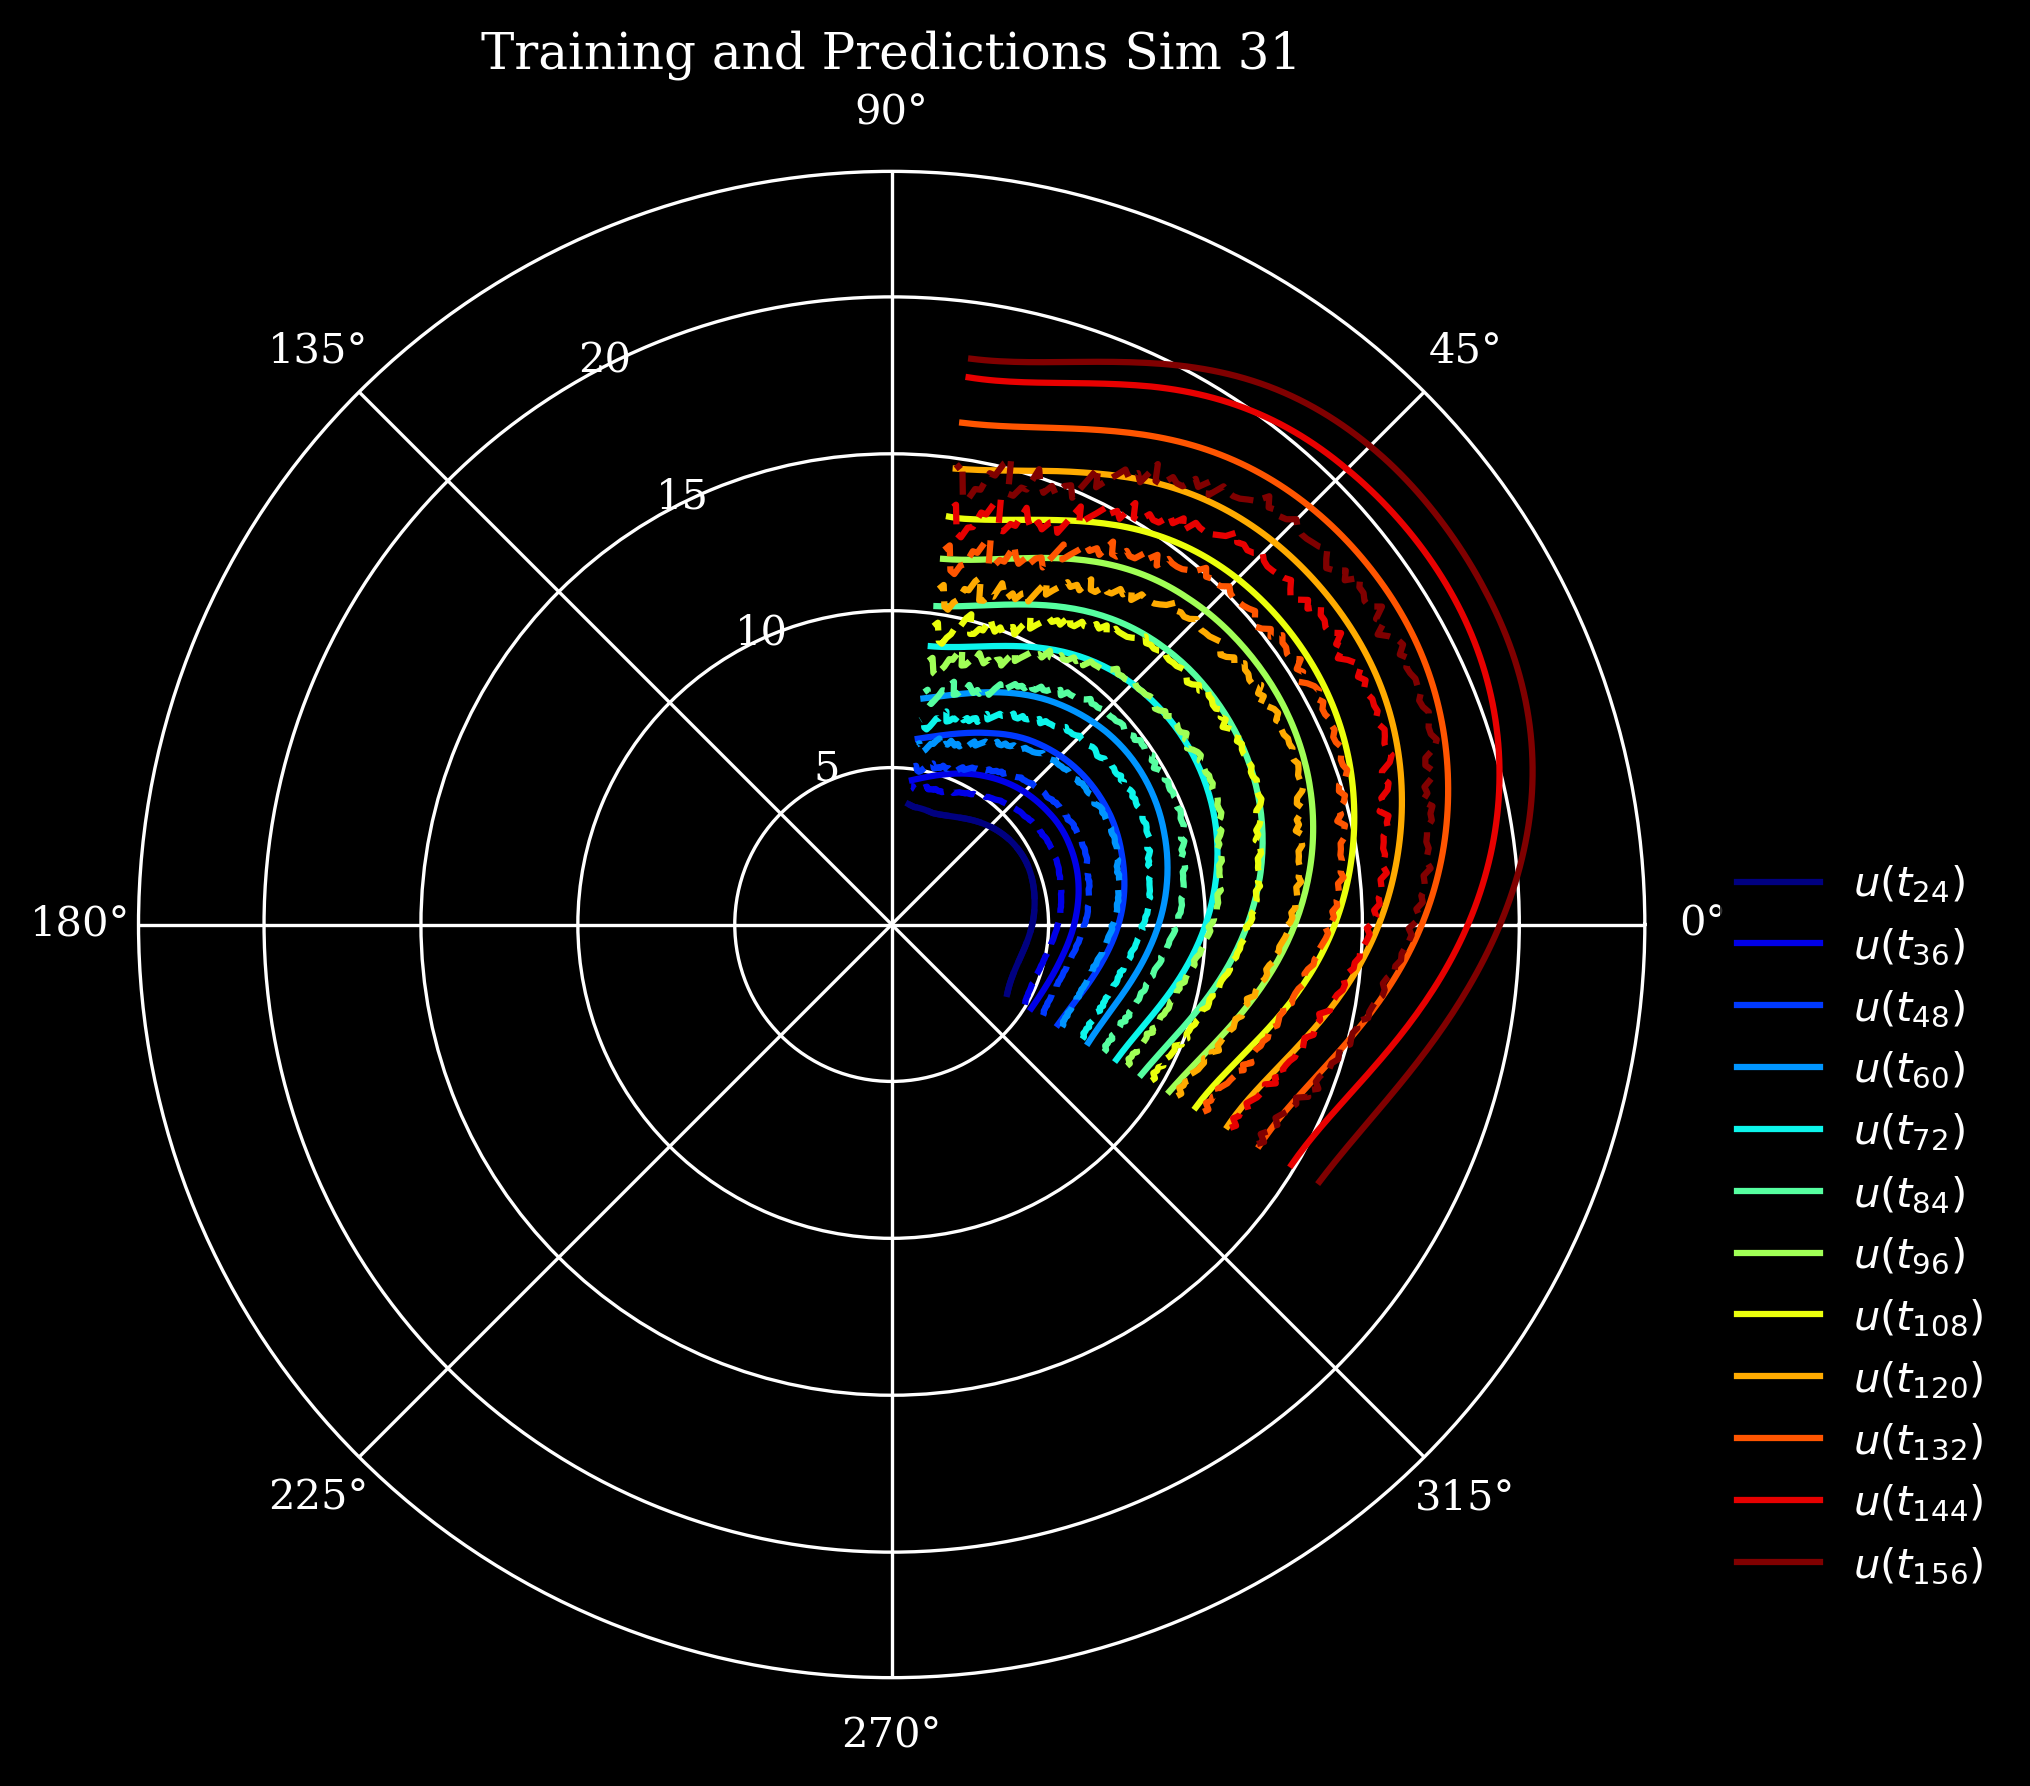

In [161]:
edut.plotTrainPredData1Model(true_y_list[0].cpu().numpy()[:, :160], pred_y_list[0].cpu().numpy()[:, :160], ed_2161, sd_2161, theta=np.linspace(-31, 82, 160), 
                        simIdx=sim_index_list[0],
                        savefig=False)

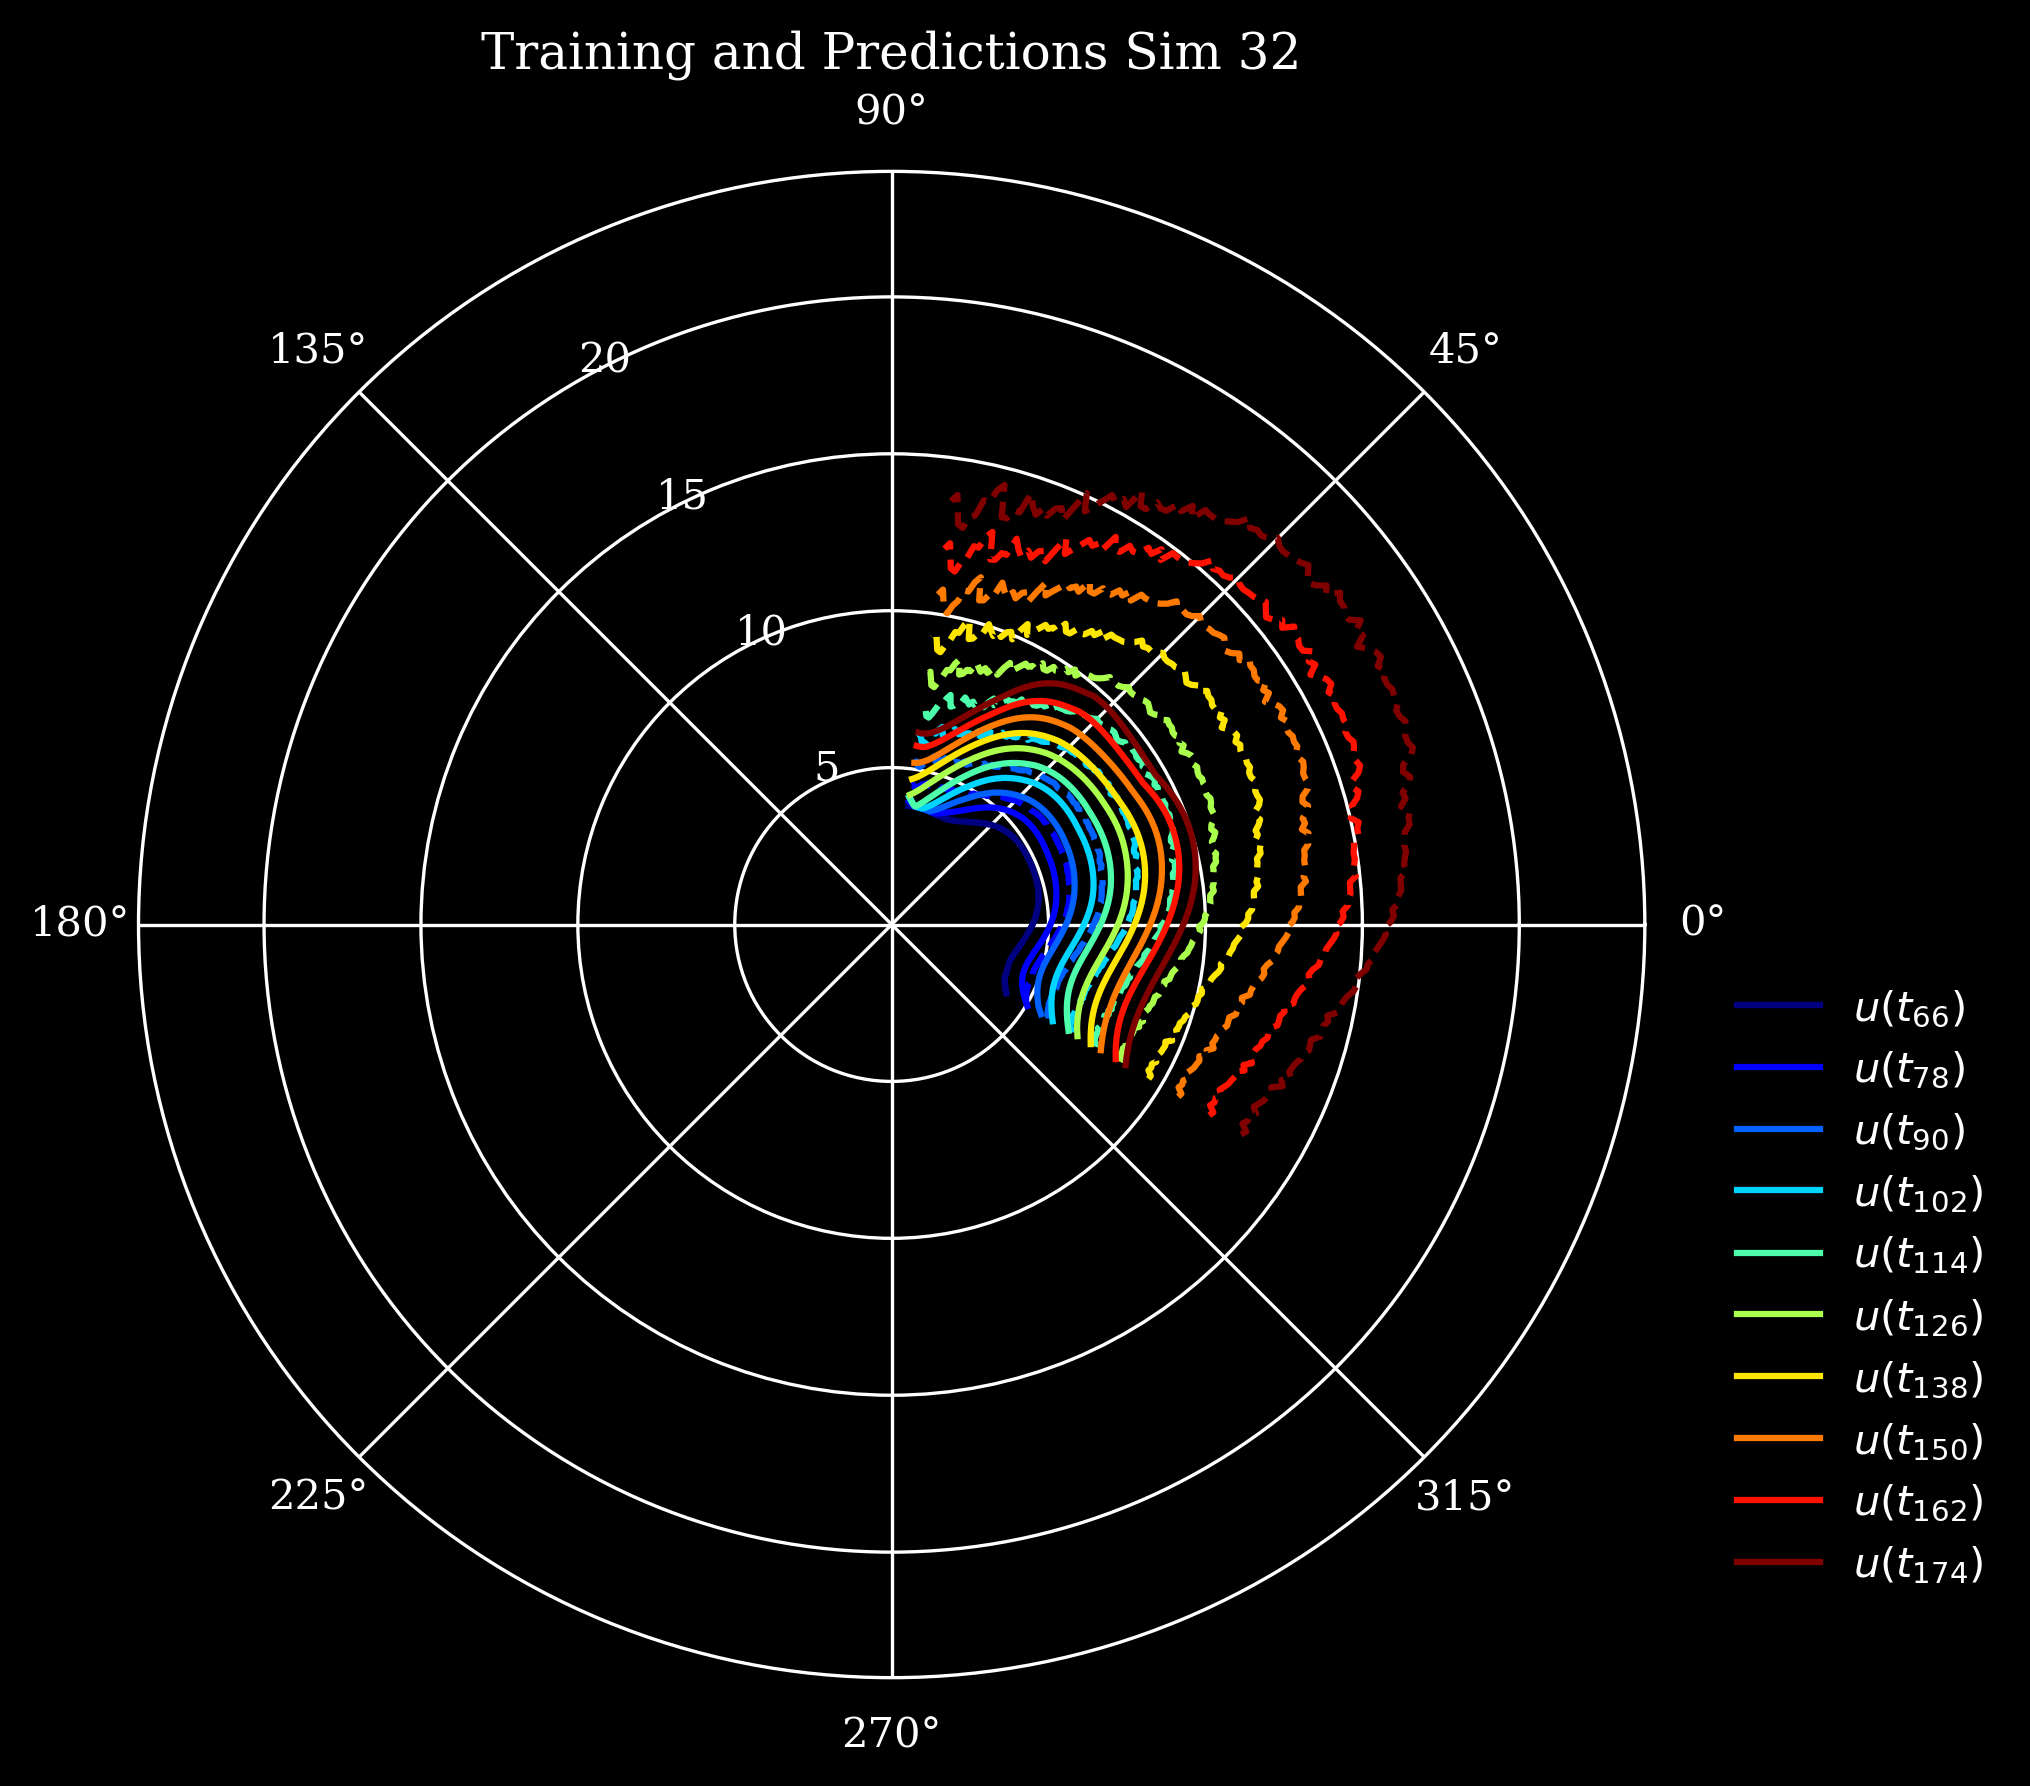

In [162]:
edut.plotTrainPredData1Model(true_y_list[1].cpu().numpy()[:, :160], pred_y_list[1].cpu().numpy()[:, :160], ed_2161, sd_2161, theta=np.linspace(-31, 82, 160), 
                        simIdx=sim_index_list[1],
                        savefig=False)

Nope even 5 sims are too hot to handle. We need a different and more clever approach.

Two tests:

1. Figure out regularization, we need to speedup training of individual sims

2. Figure out encoders

3. Figure out using fewer parameters.

In [98]:
pred_y_full_series.shape

torch.Size([74, 1, 1, 169])

In [99]:
chosen_sim

tensor(72)

In [111]:
pred_y_to_plot = pred_y_full_series.cpu().numpy()[:, 0, 0, :160]
pred_y_to_plot.shape

(74, 160)

In [112]:
y_full_to_plot = y_full_torch.cpu().numpy()[:, 0, :160]

In [113]:
y_full_to_plot.shape

(74, 160)

In [114]:
sim_index

40

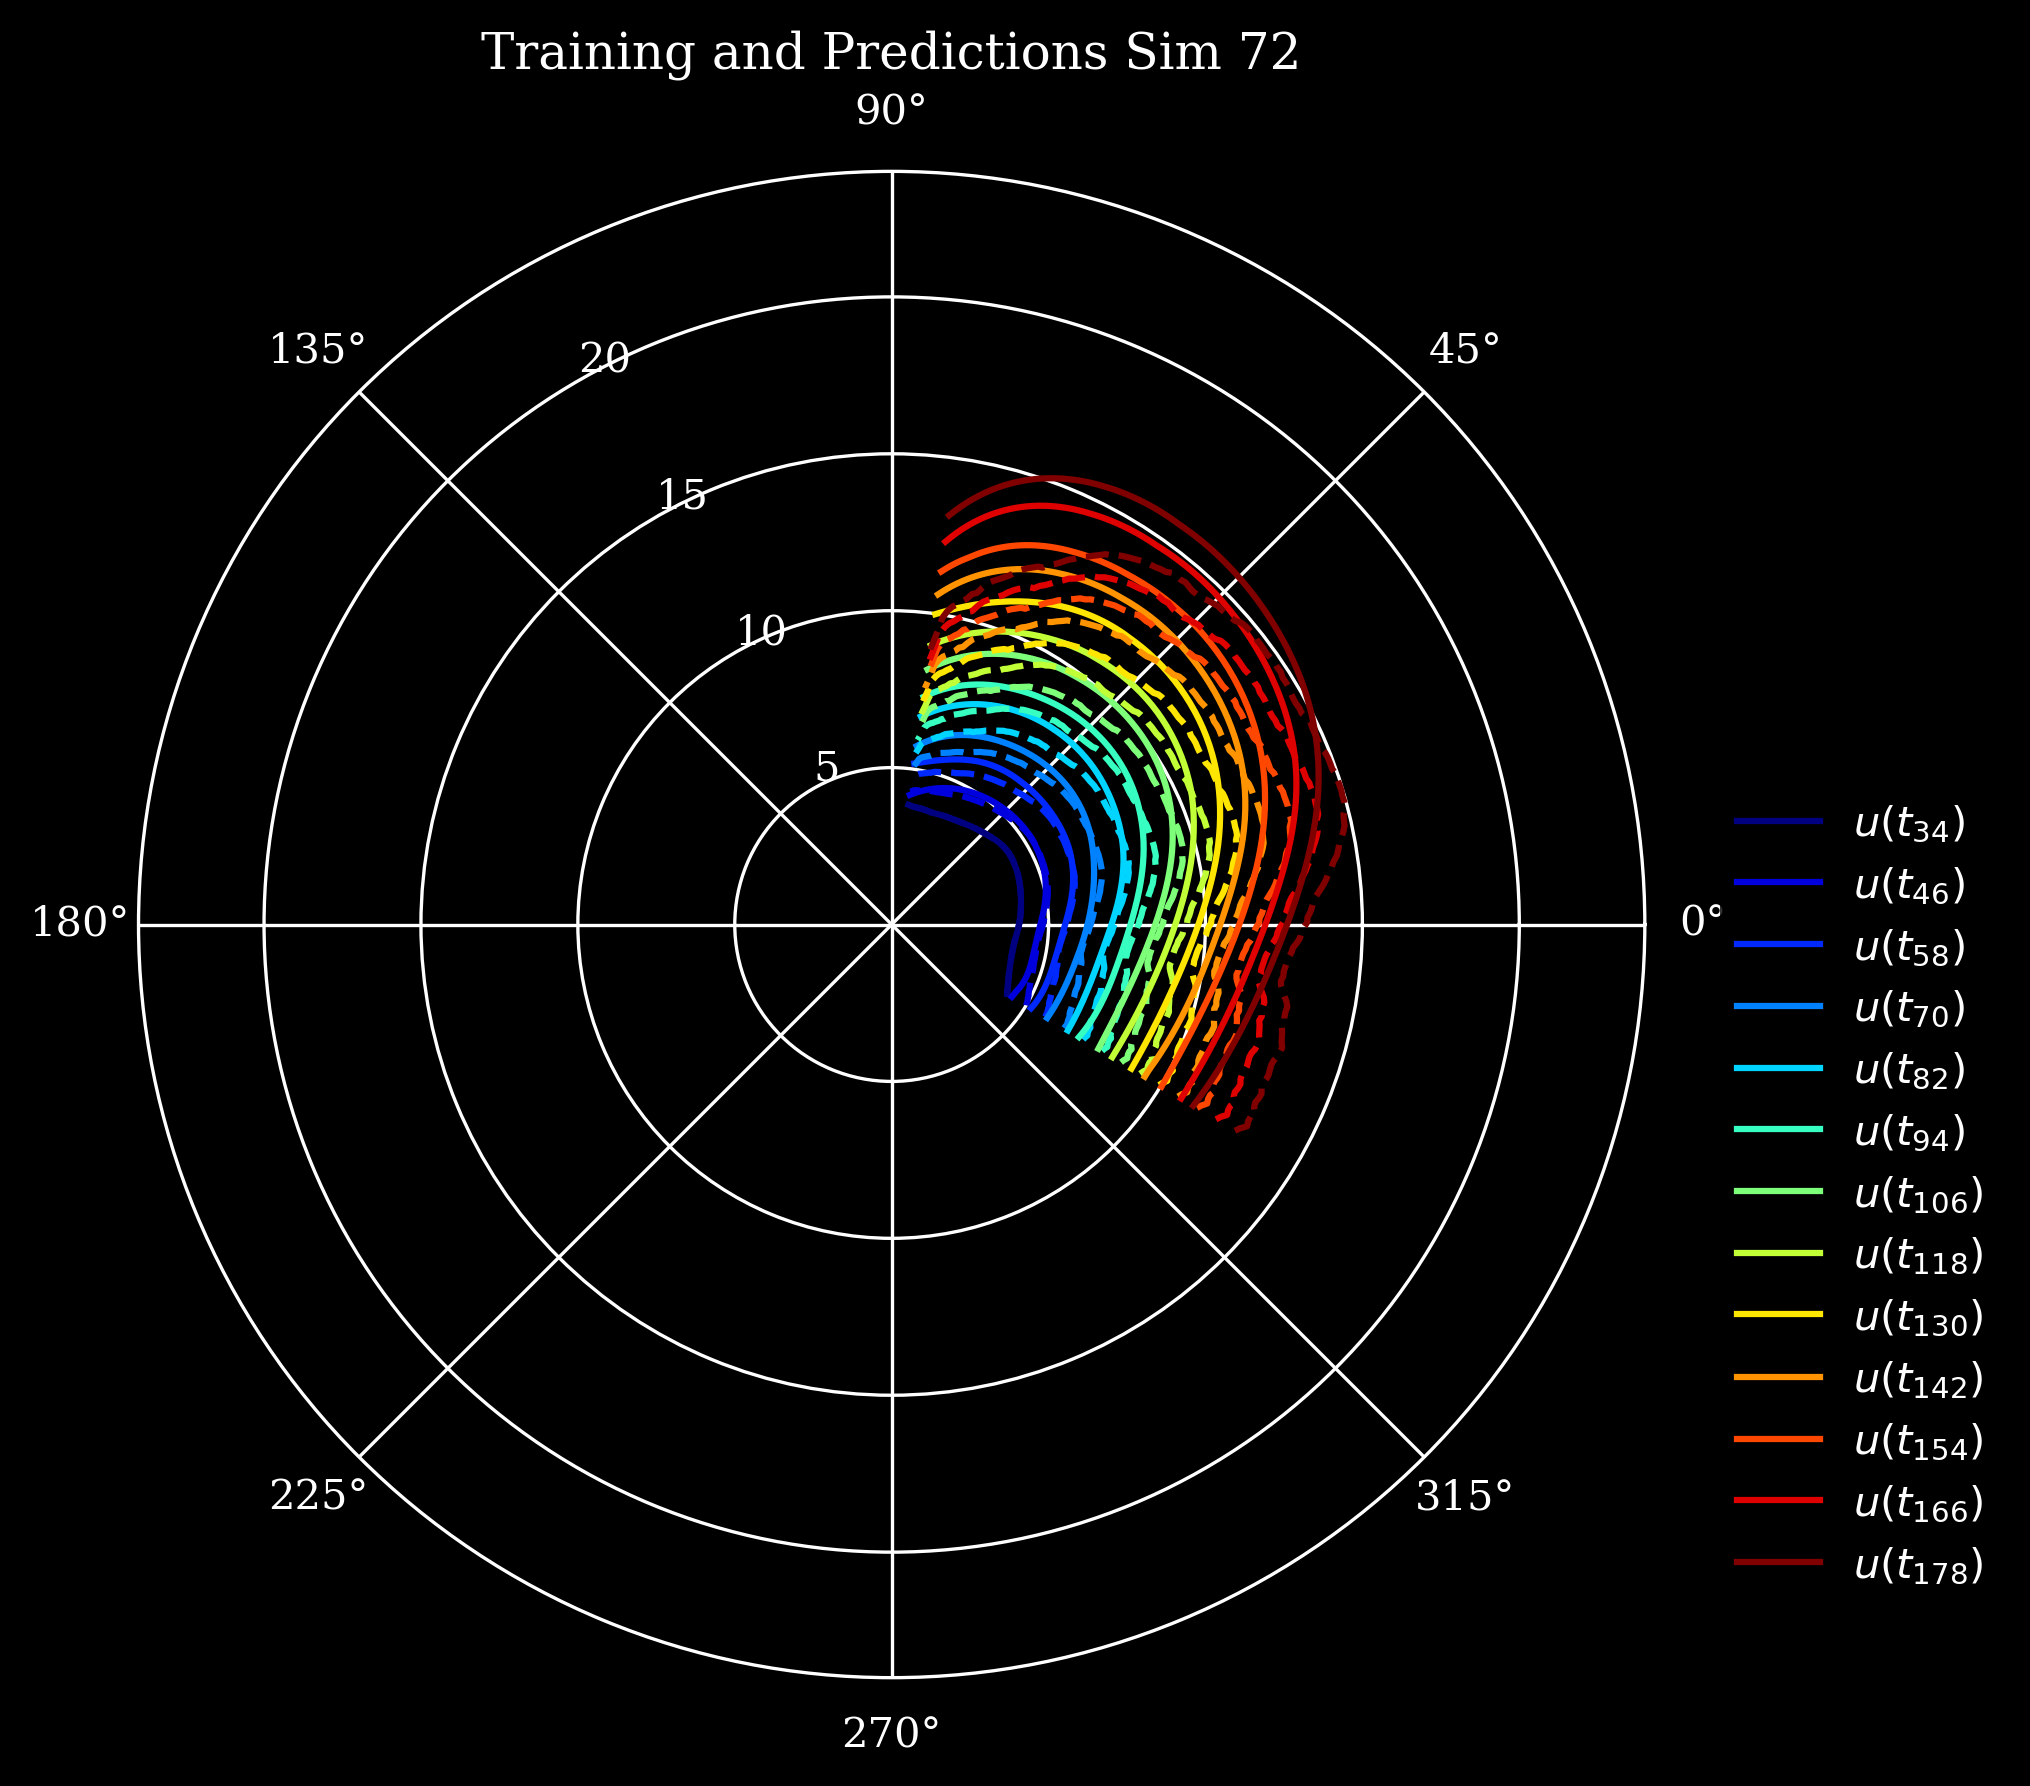

In [115]:
edut.plotTrainPredData1Model(y_full_to_plot, pred_y_to_plot, ed_2161, sd_2161, theta=np.linspace(-31, 82, 160), 
                        simIdx=40,
                        savefig=False)

In [ ]:
# chosen_sim = np.random.choice(sd_train)
# y0_train_torch,y_train_torch,y_full_torch,t_train_torch,t_scaled_torch, sim_index = getDataForSim(ed_2161,
#                                                                                                   augmented_r,
#                                                                                                   sd_2161,
#                                                                                                   chosen_sim)
# batch_y0, batch_t, batch_y = get_batch(y_train_torch, t_train_torch)                                                                                                     

In [ ]:
# def getParamsTorch(param_series, n_repeats):
#     """
#     param_series is a row from dataframe in pd. Series shape which we convert to torch tensor of suitable dims
#     """
#     return torch.from_numpy(np.float32(np.expand_dims(np.repeat(np.expand_dims(param_series.to_numpy(), axis=0), n_repeats, axis=0), axis=1)))

In [ ]:
# getParamsTorch(cme_params_norm.loc[chosen_sim - 30 - 1], 10).shape